**Import Libraries**

In [7]:
import sys
import shutil
from glob import glob
import json
import math
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import densenet
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [8]:
import tensorflow as tf
print(tf.__version__)

2.6.4


**Problem Statement**

Breast cancer is the second most common cancer in women and men worldwide. 

Breast cancer starts when cells in the breast begin to grow out of control. These cells usually form a tumor that can often be seen on an x-ray or felt as a lump. The tumor is malignant (cancer) if the cells can grow into (invade) surrounding tissues or spread (metastasize) to distant areas of the body.

**The Challenge**

Build an algorithm to automatically identify whether a patient is suffering from breast cancer or not by looking at biopsy images.

**Data**

The dataset can be downloaded from https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/. 

This is a binary classification problem. The data is split into train/test using the below script:

In [9]:
def create_folds_from_ds(dst_path='/kaggle/working'):
    """Creates a structure of directories containing images
        selected from BreaKHis_v1 dataset. 2,3,4,5
    """
    root_dir = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
    srcfiles = {'DC': '%s/malignant/SOB/ductal_carcinoma/%s/%sX/%s',
                'LC': '%s/malignant/SOB/lobular_carcinoma/%s/%sX/%s',
                'MC': '%s/malignant/SOB/mucinous_carcinoma/%s/%sX/%s',
                'PC': '%s/malignant/SOB/papillary_carcinoma/%s/%sX/%s',
                'A': '%s/benign/SOB/adenosis/%s/%sX/%s',
                'F': '%s/benign/SOB/fibroadenoma/%s/%sX/%s',
                'PT': '%s/benign/SOB/phyllodes_tumor/%s/%sX/%s',
                'TA': '%s/benign/SOB/tubular_adenoma/%s/%sX/%s'}

    
    # directory for nth-fold
    dst_dir = dst_path + '/Breast_Cancer_ Histopathological _Dataset'
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)

    # image list
    db = open('/kaggle/input/image-files-loader/load_files.txt')
    benign_train = 0
    malignant_train = 0
    
    benign_test = 0
    malignant_test = 0
    
    for row in db.readlines():
        columns = row.split('|')
        imgname = columns[0]
        types = imgname.split('_')[1]
        if types == 'B':
            category = 'benign'
        elif types == 'M':
            category = 'malignant'
        mag = columns[1]  # 40, 100, 200, or 400
        grp = columns[3].strip()  # train or test
        
        dst_subdir = dst_dir + '/' + grp
        if not os.path.exists(dst_subdir):
            os.mkdir(dst_subdir)
        
        dst_subdir = dst_subdir + '/' + category
        if not os.path.exists(dst_subdir):
            os.mkdir(dst_subdir)
            
        tumor = imgname.split('-')[0].split('_')[-1]
        srcfile = srcfiles[tumor]
        
        s = imgname.split('-')
        sub = s[0] + '_' + s[1] + '-' + s[2]
        
        srcfile = srcfile % (root_dir, sub, mag, imgname)
        
        dstfile = dst_subdir + '/' + imgname
        
        if grp == 'train' and category == 'benign':
            if benign_train >= 250:
                continue
            else:
                benign_train +=1 
        
        if grp == 'train' and category == 'malignant':
            if malignant_train >= 250:
                continue
            else:
                malignant_train +=1
        
        if grp == 'test' and category == 'benign':
            if benign_test >= 250:
                continue
            else:
                benign_test +=1
        
        if grp == 'test' and category == 'malignant':
            if malignant_test >= 250:
                continue
            else:
                malignant_test +=1
            
        print ("Copying from [%s] to [%s]" % (srcfile, dstfile))
        shutil.copy(srcfile, dstfile)
    print('\n\n\t\t Train/Test Data Creation finished.\n')
    db.close()
    print ("\nProcess completed.")

In [10]:
create_folds_from_ds()

Copying from [/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png] to [/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/benign/SOB_B_A-14-22549AB-100-001.png]
Copying from [/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png] to [/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/benign/SOB_B_A-14-22549AB-100-002.png]
Copying from [/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png] to [/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/benign/SOB_B_A-14-22549AB-100-003.png]
Copying from [/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png] to [/kaggle/working/Breast_Cancer_ 

**CNN Architecture**

THE Convolutional Neural Network (CNN) consists of the following:

1. **Convolution Layer**: 

The purpose of this layer is to receive a feature map. Usually, we start with low number of filters for low-level feature detection. The deeper we go into the CNN, the more filters we use to detect high-level features. Feature detection is based on ‘scanning’ the input with the filter of a given size and applying matrix computations in order to derive a feature map.

2. **Pooling Layer**:

The goal of this layer is to provide spatial variance, which simply means that the system will be capable of recognizing an object even when its appearance varies in some way. Pooling layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in output such as [16x16x12] for pooling_size=(2, 2)

3. **Fully Connected Layer**:

In a fully connected layer, we flatten the output of the last convolution layer and connect every node of the current layer with the other nodes of the next layer. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks and work in a similar way.

**Image Classification**

The complete image classification pipeline can be formalized as follows:

* Our input is a training dataset that consists of N images, each labeled with one of 2 different classes.

* Then, we use this training set to train a classifier to learn what every one of the classes looks like.

* In the end, we evaluate the quality of the classifier by asking it to predict labels for a new set of images that it has never seen before. We will then compare the true labels of these images to the ones predicted by the classifier.

**Load the Image from respective folders**

In [11]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/benign/',224))
malign_train = np.array(Dataset_loader('/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/malignant/',224))
benign_test = np.array(Dataset_loader('/kaggle/working/Breast_Cancer_ Histopathological _Dataset/test/benign/',224))
malign_test = np.array(Dataset_loader('/kaggle/working/Breast_Cancer_ Histopathological _Dataset/test/malignant/',224))

100%|██████████| 250/250 [00:03<00:00, 72.65it/s]


After loading the images, create a numpy array of zeroes for labeling benign images and similarly a numpy array of ones for labeling malignant images. 

Also shuffled the dataset and converted the labels into categorical format.

In [12]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
print('Number of training images', X_train.shape[0])

np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
print('Number of testing images', X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

Number of training images 500
Number of testing images 500


**Train-Test Split**

Split the data-set into two sets — train and test sets with 80% and 20% images respectively

In [13]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=0
)

Let’s see some sample benign and malignant images.

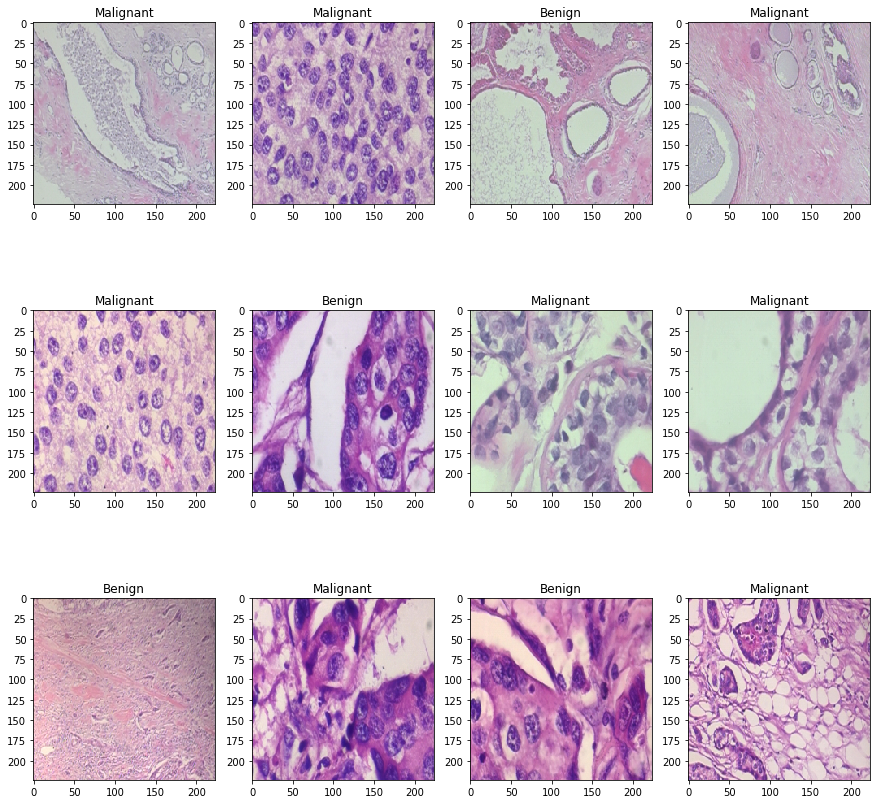

In [14]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

**Batch Size**

Batch size is one of the most important hyperparameters to tune in deep learning. A larger batch size trains models as it allows computational speedups from the parallelism of GPUs. However, it is well known that too large of a batch size will lead to poor generalization. On the one extreme, using a batch equal to the entire dataset guarantees convergence to the global optima of the objective function. However this is at the cost of slower convergence to that optima. On the other hand, using smaller batch sizes have been shown to have faster convergence to good results. This is intuitively explained by the fact that smaller batch sizes allow the model to start learning before having to see all the data. The downside of using a smaller batch size is that the model is not guaranteed to converge to the global optima.Therefore it is often advised that one starts at a small batch size reaping the benefits of faster training dynamics and steadily grows the batch size through training.

**Data Augmentation**

The practice of data augmentation is an effective way to increase the size of the training set. Augmenting the training examples allow the network to see more diversified, but still representative data points during training.

In [16]:
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

**Building the Model**

This can be described in the following 3 steps:

* Use ResNet101V2 as the pre trained weights which is already trained in the Imagenet competition. The learning rate was chosen to be 0.0001.

* On top of it, use a globalaveragepooling layer followed by 50% dropouts to reduce over-fitting.

* Use batch normalization and a dense layer with 2 neurons for 2 output classes ie benign and malignant with softmax as the activation function.

* Use Adam as the optimizer and binary-cross-entropy as the loss function.

## Implement the patch extraction and encoding layer

In [18]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


## Implement the external attention block

In [19]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

## Implement the MLP block

In [20]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

## Implement the Transformer block

In [21]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

## Implement the EANet model

In [22]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
input_shape=(224, 224, 3)
num_classes=2
BATCH_SIZE = 4

In [27]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 12544


In [28]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="/kaggle/working/best_checkpoint.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#Train Model
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint])

Epoch 1/5
100/100 [==============================] - 51s 390ms/step - loss: 0.3593 - accuracy: 0.9300 - top-5-accuracy: 1.0000 - val_loss: 0.2837 - val_accuracy: 0.9700 - val_top-5-accuracy: 1.0000
Epoch 2/5
100/100 [==============================] - 37s 373ms/step - loss: 0.2634 - accuracy: 0.9850 - top-5-accuracy: 1.0000 - val_loss: 0.3258 - val_accuracy: 0.9700 - val_top-5-accuracy: 1.0000
Epoch 3/5
100/100 [==============================] - 38s 378ms/step - loss: 0.2517 - accuracy: 0.9875 - top-5-accuracy: 1.0000 - val_loss: 0.2681 - val_accuracy: 0.9900 - val_top-5-accuracy: 1.0000
Epoch 4/5
100/100 [==============================] - 38s 381ms/step - loss: 0.2362 - accuracy: 0.9900 - top-5-accuracy: 1.0000 - val_loss: 0.2575 - val_accuracy: 0.9900 - val_top-5-accuracy: 1.0000
Epoch 5/5
100/100 [==============================] - 38s 382ms/step - loss: 0.2363 - accuracy: 0.9875 - top-5-accuracy: 1.0000 - val_loss: 0.3272 - val_accuracy: 0.9700 - val_top-5-accuracy: 1.0000


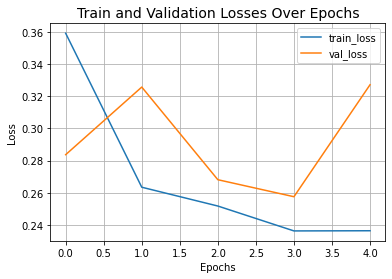

In [29]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [32]:
loss, accuracy, top_5_accuracy = model.evaluate(x_val, y_val)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

4/4 [==============================] - 3s 636ms/step - loss: 0.3272 - accuracy: 0.9700 - top-5-accuracy: 1.0000
Test loss: 0.33
Test accuracy: 97.0%
Test top 5 accuracy: 100.0%


EANet just replaces self attention in Vit with external attention. The traditional Vit achieved a ~73% test top-5 accuracy and ~41 top-1 accuracy after training 50 epochs, but with 0.6M parameters. Under the same experimental environment and the same hyperparameters, The EANet model we just trained has just 0.3M parameters, and it gets us to ~73% test top-5 accuracy and ~43% top-1 accuracy. This fully demonstrates the effectiveness of external attention. We only show the training process of EANet, you can train Vit under the same experimental conditions and observe the test results.

**Model Callbacks**

Before training the model, it is useful to define one or more callbacks. Pretty handy one, are: ModelCheckpoint and ReduceLROnPlateau.

* **ModelCheckpoint**: When training requires a lot of time to achieve a good result, often many iterations are required. In this case, it is better to save a copy of the best performing model only when an epoch that improves the metrics ends.

* **ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2–10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.

**Model Training**

Model was trained for 5 epochs

In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="/kaggle/working/best_checkpoint.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#Train Model
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint])

**Model Loss/Accuracy curve**

In [33]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,top-5-accuracy,val_loss,val_accuracy,val_top-5-accuracy,lr
0,0.359290,0.9300,1.0,0.283700,0.97,1.0,0.001
1,0.263440,0.9850,1.0,0.325781,0.97,1.0,0.001
2,0.251729,0.9875,1.0,0.268113,0.99,1.0,0.001
3,0.236239,0.9900,1.0,0.257526,0.99,1.0,0.001
4,0.236347,0.9875,1.0,0.327228,0.97,1.0,0.001


<AxesSubplot:>

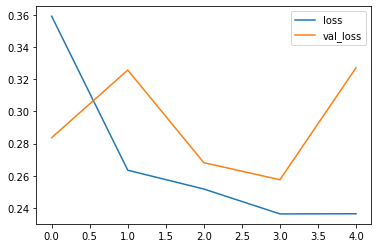

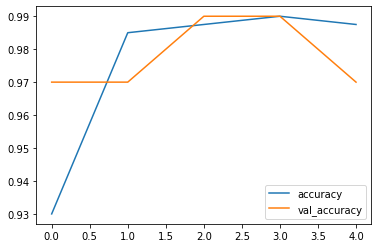

In [34]:
history_df[['loss', 'val_loss']].plot()

history_df[['accuracy', 'val_accuracy']].plot()

**Prediction**

In [35]:
Y_pred = model.predict(x_val)

In [36]:
print('Model Accuracy score', accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1)))

Model Accuracy score 0.97


**Performance Metrics**

The most common metric for evaluating model performance is the accurcacy. However, when only 2% of your dataset is of one class (malignant) and 98% some other class (benign), misclassification scores don’t really make sense. You can be 98% accurate and still catch none of the malignant cases which could make a terrible classifier.

**Precision, Recall and F1-Score**

For a better look at misclassification, we often use the following metric to get a better idea of true positives (TP), true negatives (TN), false positive (FP) and false negative (FN).

**Precision** is the ratio of correctly predicted positive observations to the total predicted positive observations.

**Recall** is the ratio of correctly predicted positive observations to all the observations in actual class.

**F1-Score** is the harmonic mean of Precision and Recall.

**Confusion Matrix**

Confusion Matrix is a very important metric when analyzing misclassification. Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class. The diagonals represent the classes that have been correctly classified. This helps as we not only know which classes are being misclassified but also what they are being misclassified as.

In [37]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████| 10/10 [03:54<00:00, 23.47s/it]


Confusion matrix, without normalization
[[241   9]
 [ 31 219]]


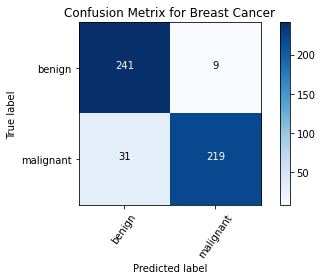

In [39]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

In [40]:
from sklearn.metrics import classification_report

classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.89      0.96      0.92       250\n           1       0.96      0.88      0.92       250\n\n    accuracy                           0.92       500\n   macro avg       0.92      0.92      0.92       500\nweighted avg       0.92      0.92      0.92       500\n'

**ROC Curves**

The 45 degree line is the random line, where the Area Under the Curve or AUC is 0.5 . The further the curve from this line, the higher the AUC and better the model. The highest a model can get is an AUC of 1, where the curve forms a right angled triangle. The ROC curve can also help debug a model. For example, if the bottom left corner of the curve is closer to the random line, it implies that the model is misclassifying at Y=0. Whereas, if it is random on the top right, it implies the errors are occurring at Y=1.

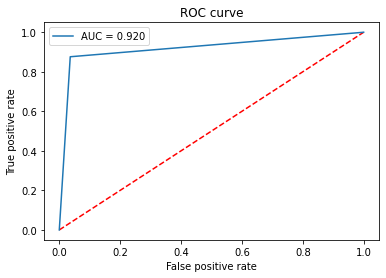

In [41]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

**Conclusions**

It is remarkable to see the success of deep learning in such varied real world problems. In this blog, we have demonstrated how to classify benign and malignant breast cancer from a collection of microscopic images using convolutional neural networks and transfer learning.